# Regression models with Stock price data

**Using the exact same code applied to the Airlines and Champagne datasets, run a closing stock time series through the more traditional regression models. Remember that the dataset contains multiple company stocks so you need to filter the data to obtain univariate time series, e.g. closing stock prices for IBM.**

**NOTE: Linear Regression is linear, while Support Vector Regression and Random Forest Regression are non-linear.**

**NOTE: The time series frequency is in trading days, which cannot be defined by programming like business or calendar days.**

**In this exercise, you will difference the logged values to ensure as much stationarity as possible. Remember that stock prices are quite difficult to predict, so you have to make the time series stationary otherwise the model will just pick the last known value, which is misleading.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
# Dataset contains multiple company stocks so intialize name as df0

df0 = pd.read_csv('data/sp500sub.csv', index_col='Date', parse_dates=True)

In [4]:
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [5]:
# Obtain time series from IBM

df = df0[df0['Name'] == 'IBM'][['Close']].copy()

In [6]:
df['LogClose'] = np.log(df['Close'])

In [7]:
df['DiffLogClose'] = df['LogClose'].diff()

In [8]:
# Note 1st value in diffed column is null (due to differencing)

df.head()

,Close,LogClose,DiffLogClose
Date,,,
2010-01-04,132.449997,4.886205,NaN
2010-01-05,130.850006,4.874052,-0.012154
2010-01-06,130.000000,4.867534,-0.006517
2010-01-07,129.550003,4.864067,-0.003468
2010-01-08,130.850006,4.874052,0.009985


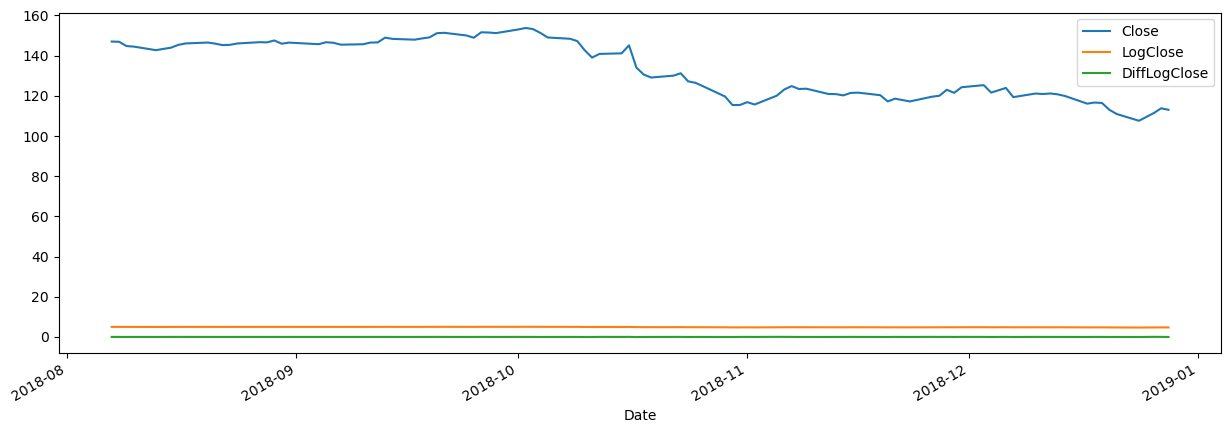

In [11]:
df[-100:].plot(figsize=(15, 5));

In [9]:
# Create training and test sets

N_test = 12

train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

## Make 'supervised' dataset for one-step and incremental multi-step forecasts

**NOTE: The data is quite large, so training will take longer.**

In [12]:
# Use T past values to predict the next value

series = df['DiffLogClose'].to_numpy()[1:]

T = 21
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2241, 21) Y.shape (2241,)


In [13]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-N_test], Y[:-N_test]

X_test, y_test = X[-N_test:], Y[-N_test:]

## Linear Regression model

In [14]:
lr = LinearRegression()

lr.fit(X_train, y_train)

print("Train R2 score:", lr.score(X_train, y_train))

Train R2 score: 0.00910676388568643


In [15]:
print("Test R2 score:", lr.score(X_test, y_test))

Test R2 score: -0.10647843085489139


**Yikes! Negative R-Squared score on test set indicates badly fitted model, i.e. the model cannot learn the data at all, it is just predicting the last known value.**

In [16]:
# Boolean index data to reference train and test

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# First T + 1 values are not predictable (+1 because of differencing)

train_idx[:T+1] = False 

In [17]:
# Compute un-differenced predictions by shifting logged values up by one

df['ShiftLogClose'] = df['LogClose'].shift(1)

prev = df['ShiftLogClose']

In [18]:
# Obtain last-known train value for multi-step forecast

last_train = train.iloc[-1]['LogClose']

## One-step forecast

In [19]:
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(X_train)

df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(X_test)

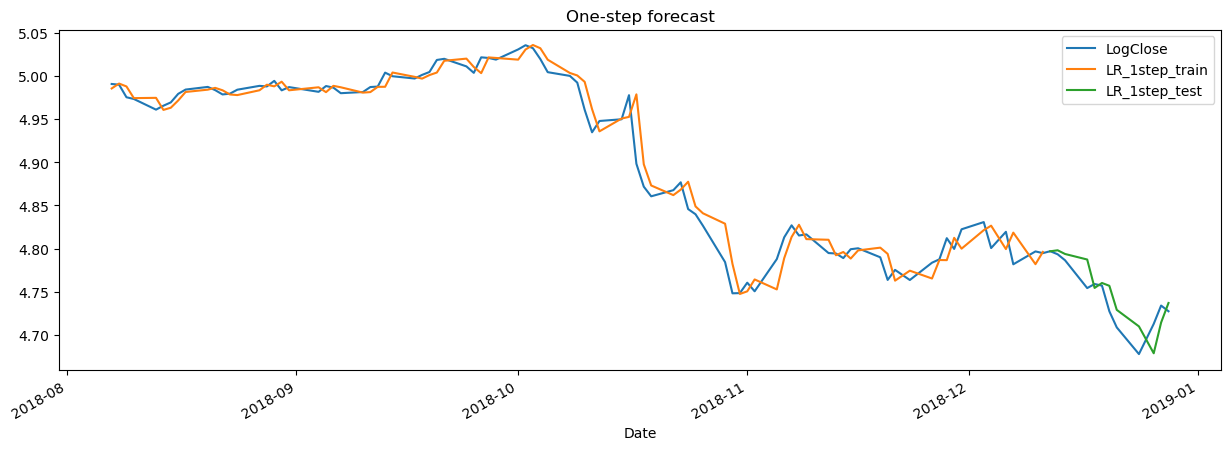

In [20]:
# Plot 1-step forecast

cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']

df.iloc[-100:][cols].plot(figsize=(15, 5))
plt.title("One-step forecast");

**It looks like the predictions lag the time series, i.e. pick the previous value, which was already surmised from the R-Squared scores. So even though this plot looks like the predictions follow the data to a degree, this is misleading.**

## Incremental Multi-step forecast

In [21]:
# Generate multi-step predictions

multistep_predictions = []

# Obtain first test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [22]:
# Save multi-step forecast to dataframe

df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

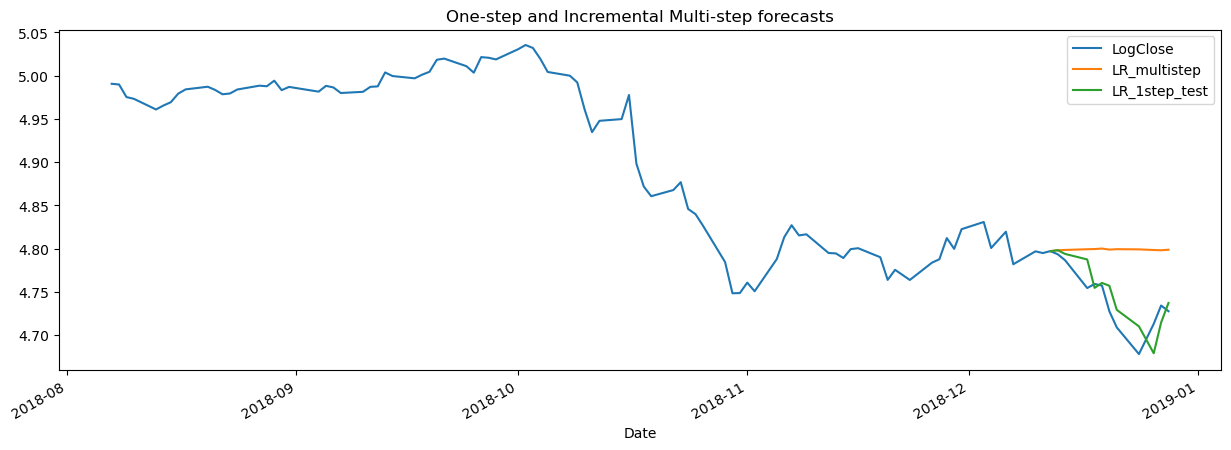

In [23]:
# Plot 1-step and multi-step forecast together

cols = ['LogClose', 'LR_multistep', 'LR_1step_test']

df.iloc[-100:][cols].plot(figsize=(15, 5))
plt.title("One-step and Incremental Multi-step forecasts");

**As expected, the incremental multi-step is forecasting last known value from training set.**

## Multi-output Multi-step forecast

**First you must make a new 'supervised' dataset with multiple outputs, then re-train the model with the new dataset.**

In [24]:
Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2230, 21) Y.shape (2230, 12)


In [25]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

**Re-train Regression model.**

In [26]:
lr = LinearRegression()

lr.fit(Xtrain, Ytrain)

print("Train R2 score:", lr.score(Xtrain, Ytrain))

Train R2 score: 0.010010133087048317


In [27]:
print("Test R2 score:")

r2_score(lr.predict(Xtest).flatten(), Ytest.flatten())

Test R2 score:


-489.9493800611157

**Even worse! This indicates that the data is just noise to the model.**

In [28]:
# Save multi-output forecast to dataframe

df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest).flatten())

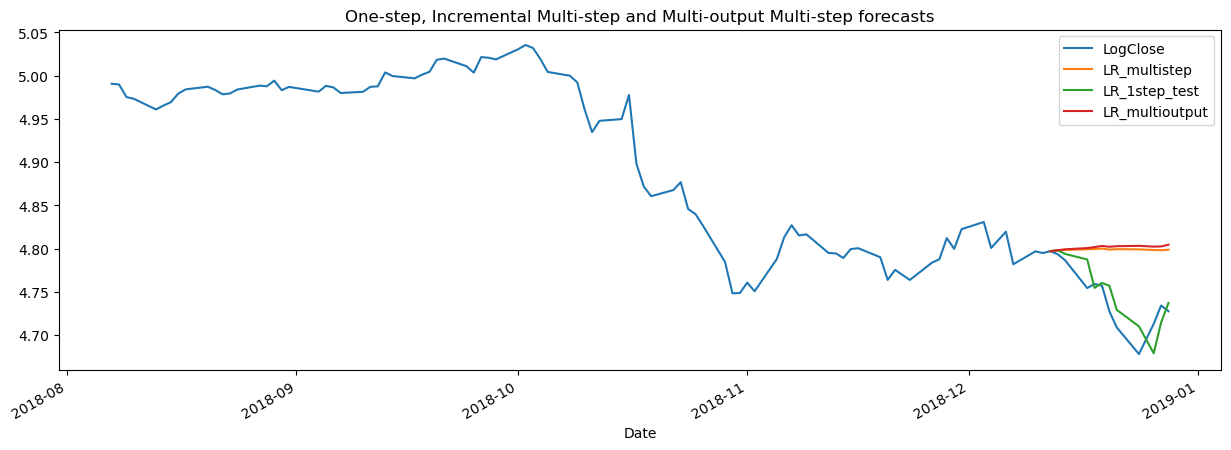

In [29]:
# Plot all forecasts

cols = ['LogClose', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']

df.iloc[-100:][cols].plot(figsize=(15, 5))
plt.title("One-step, Incremental Multi-step and Multi-output Multi-step forecasts");

In [30]:
# Compute MAPE for multi-step methods

test_log_pass = df.iloc[-N_test:]['LogClose']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.01142632609085105
multi-output MAPE: 0.011998190671272594


**The multi-output forecast looks to be the worst, which is confirmed by the MAPE score. The one-step forecast looks to be the best, but as we already know, that is misleading because it is just picking the previous value.**

## Test other Regression models

**Create custom function to generate one-step and incremental multi-step forecasts.**

In [31]:
def one_step_and_multistep_forecast(model, name):
    model.fit(X_train, y_train)
    print("One-step forecast:", name)
    print("Train R^2:", model.score(X_train, y_train))
    print("Test R^2 (1-step):", model.score(X_test, y_test))
    
    # Store 1-step forecast 
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(X_train)
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(X_test)
    
    # Generate multi-step forecast
    multistep_predictions = []
    
    # Obtain first test input
    last_x = X_test[0]
    
    while len(multistep_predictions) < N_test:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # Update the predictions list
        multistep_predictions.append(p)
        
        # Make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    # Store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)
    
    # Plot 1-step and multi-step forecast
    cols = ['LogClose', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df.iloc[-100:][cols].plot(figsize=(15, 5));

One-step forecast: SVR
Train R^2: -0.0034834150203573166
Test R^2 (1-step): -0.06102110060806987
Test MAPE (multi-step): 0.009692971150318395


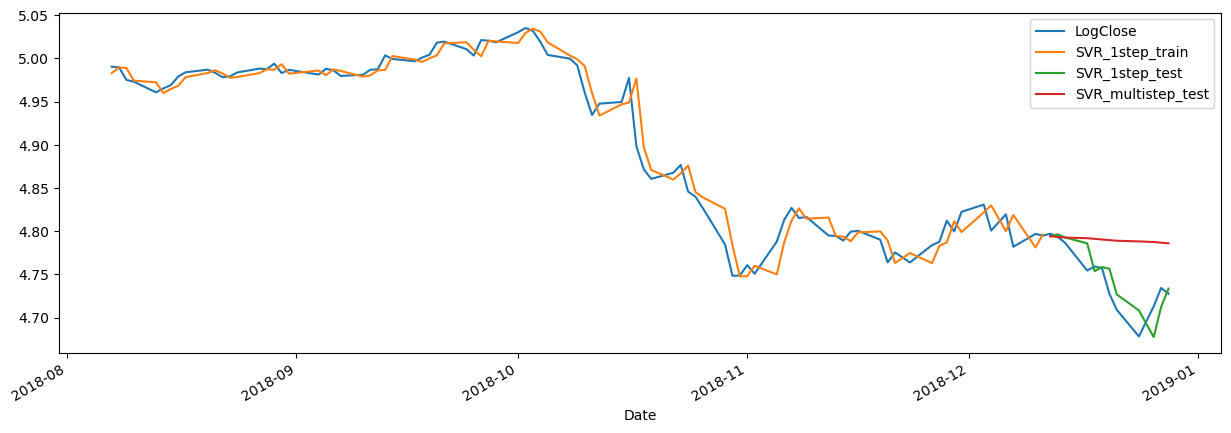

In [32]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Train R^2: 0.8566099481084808
Test R^2 (1-step): -0.24526688103300986
Test MAPE (multi-step): 0.014022625841714959


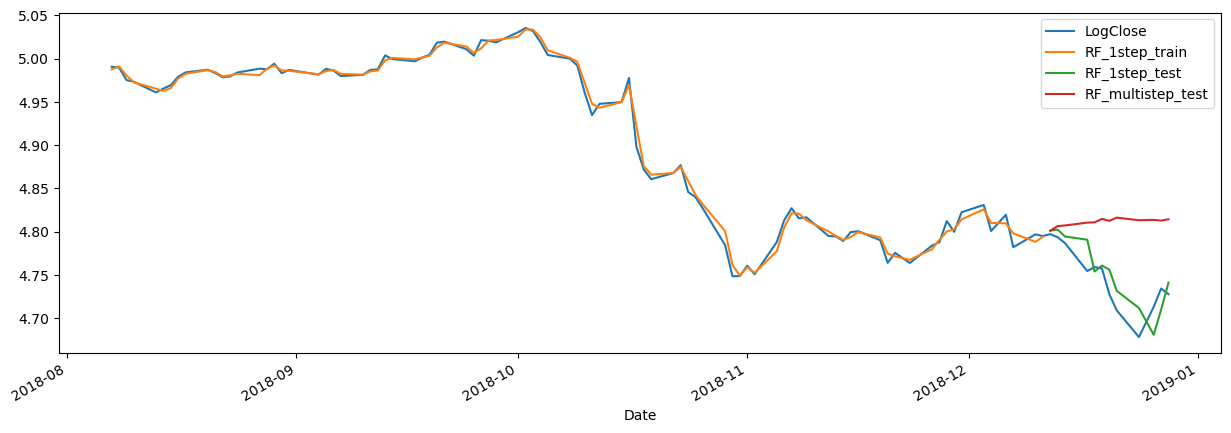

In [33]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

**Both Support Vector Machine and Random Forest behave similar to Linear Regression model. Although notice how the Random Forest fits the training set. If you had to choose one based on one-step and incremental multi-step forecasts, SVR has the best results.**

**Create custom function to generate multi-output multi-step forecasts.**

**NOTE: Support Vector Machine cannot handle multiple outputs, but you can use the `SVRWrapper` Class to implement multiple SVRs for each output.**

In [34]:
def multi_output_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    
    # Save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(Xtest).flatten())
    
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)
    
    # Plot all forecasts assuming that previous functions have been run
    cols = ['LogClose', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']
    df.iloc[-100:][cols].plot(figsize=(15, 5));

Test MAPE (multi-output): 0.012456756129948775


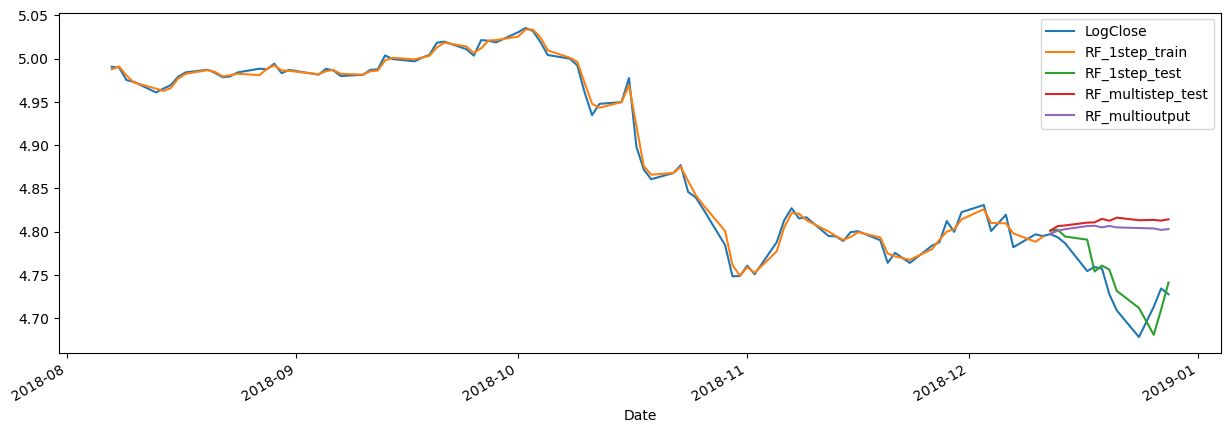

In [35]:
multi_output_forecast(RandomForestRegressor(), "RF")

**The multi-output forecasts from Random Forest improve slightly on the incremental method, but the performance is still not good enough, which is not surprising.**

**In conclusion, even though you expected Linear Regression to fail at predicting stock prices, maybe you hoped that the non-linear regression models would be able to capture some non-linear patterns, but that is not the case. So far, the traditional regression model are unable to predict stock prices.**